# Описание проекта "Прогнозирование заказов такси"

**Дано:**
Исторические данные о заказах такси в аэропортах.
  
**Требуется:**
Модель предсказания количества заказов такси на следующий час.
  
**Замечания:**
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression
from sklearn.tree             import DecisionTreeRegressor
from sklearn.ensemble         import RandomForestRegressor
from sklearn.metrics          import mean_squared_error

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi.index.min()

Timestamp('2018-03-01 00:00:00')

In [6]:
taxi.index.max()

Timestamp('2018-08-31 23:50:00')

Сортировка по возрастанию даты

In [7]:
taxi.sort_index(inplace=True)

Ресемплирование по одному часу

In [8]:
taxi = taxi.resample('1H').sum()

In [9]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

<AxesSubplot:xlabel='datetime'>

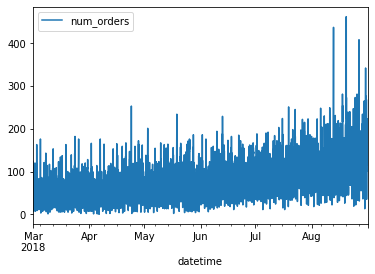

In [10]:
taxi.plot()

**Замечания:**
* среднее значение и дисперсия со временем изменяются, хоть и не сильно.

# Выводы
* временной ряд нестационарный.

Декомпозиция временного ряда.

In [11]:
decomposed = seasonal_decompose(taxi['num_orders'])

<AxesSubplot:xlabel='datetime'>

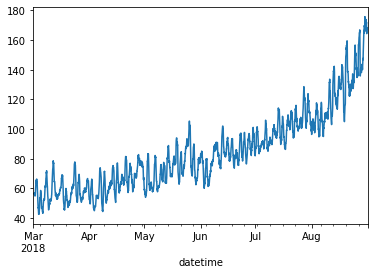

In [12]:
decomposed.trend.plot()

<AxesSubplot:xlabel='datetime'>

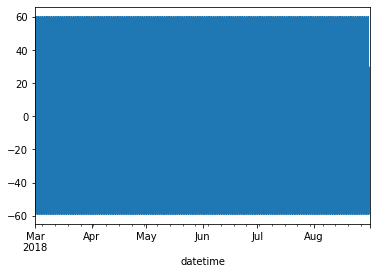

In [13]:
decomposed.seasonal.plot()

<AxesSubplot:xlabel='datetime'>

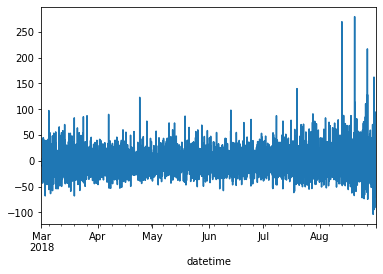

In [14]:
decomposed.resid.plot()

**Замечания:**
* на всем объеме данных (в течении полугода) графики малоинформативны.

Тренд, сезонность и остаток в течении недели.

<AxesSubplot:xlabel='datetime'>

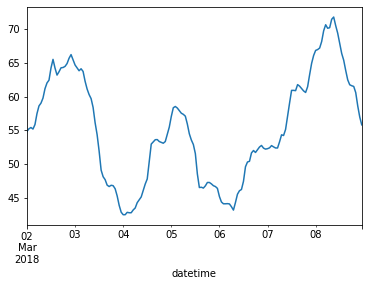

In [15]:
decomposed.trend['2018-03-02':'2018-03-08'].plot()

<AxesSubplot:xlabel='datetime'>

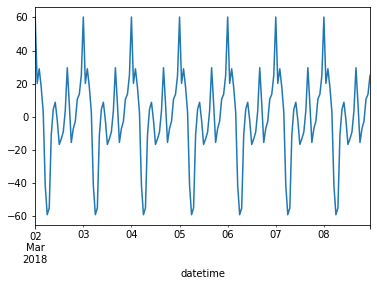

In [16]:
decomposed.seasonal['2018-03-02':'2018-03-08'].plot()

<AxesSubplot:xlabel='datetime'>

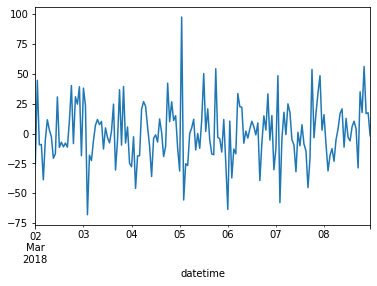

In [17]:
decomposed.resid['2018-03-02':'2018-03-08'].plot()

Тренд, сезонность и остаток в течении суток.

<AxesSubplot:xlabel='datetime'>

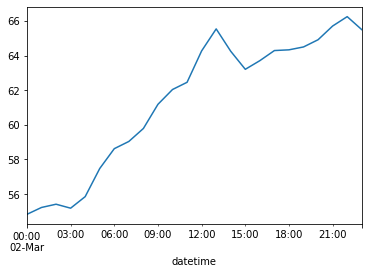

In [18]:
decomposed.trend['2018-03-02':'2018-03-02'].plot()

<AxesSubplot:xlabel='datetime'>

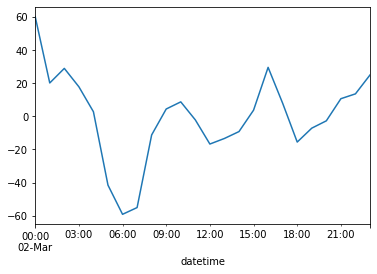

In [19]:
decomposed.seasonal['2018-03-02':'2018-03-02'].plot()

<AxesSubplot:xlabel='datetime'>

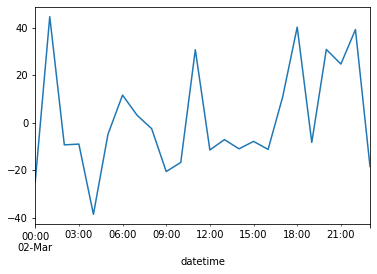

In [20]:
decomposed.resid['2018-03-02':'2018-03-02'].plot()

**Замечания:**
* в `тренде` наблюдается недельный период колебаний;
* в `сезонности` наблюдается дневной период колебаний;
* среднее колебаний `остатка` равно нулю.

"Стационаризация" временного ряда

In [21]:
taxi = taxi - taxi.shift(fill_value=0)

<AxesSubplot:xlabel='datetime'>

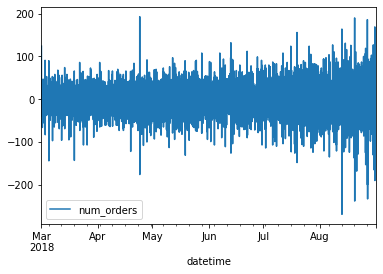

In [22]:
taxi.plot()

**Замечания:**
* среднее значение визуально стало стационарным;
* наблюдает некоторое увеличение дисперсии со временем.

# Выводы
* обработанный временной ряд пригоден для построения прогнозов.

## Обучение

Функция создания признаков

In [23]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour']      = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

В виду ярко выраженных суточных периодов коллебания спроса, принимаем период для расчета скользящего среднего и лаг в размере одних суток.

In [24]:
make_features(data             =taxi,
              max_lag          =24,
              rolling_mean_size=24)

In [25]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   dayofweek     4416 non-null   int64  
 2   hour          4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  lag_9         4407 non-null   float64
 12  lag_10        4406 non-null   float64
 13  lag_11        4405 non-null   float64
 14  lag_12        4404 non-null   float64
 15  lag_13        4403 non-null   float64
 16  lag_14        4402 non-null   float64
 17  lag_15        4401 non-null

In [26]:
taxi.isna().mean()

num_orders      0.000000
dayofweek       0.000000
hour            0.000000
lag_1           0.000226
lag_2           0.000453
lag_3           0.000679
lag_4           0.000906
lag_5           0.001132
lag_6           0.001359
lag_7           0.001585
lag_8           0.001812
lag_9           0.002038
lag_10          0.002264
lag_11          0.002491
lag_12          0.002717
lag_13          0.002944
lag_14          0.003170
lag_15          0.003397
lag_16          0.003623
lag_17          0.003850
lag_18          0.004076
lag_19          0.004303
lag_20          0.004529
lag_21          0.004755
lag_22          0.004982
lag_23          0.005208
lag_24          0.005435
rolling_mean    0.005435
dtype: float64

In [27]:
taxi.dropna(inplace=True)

In [28]:
target   = taxi['num_orders']
features = taxi.drop(['num_orders'],axis=1)

In [29]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(features,
                                                                                        target,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)

features_train, features_valid, target_train, target_valid           = train_test_split(features_train_valid,
                                                                                        target_train_valid,
                                                                                        test_size=0.25,
                                                                                        shuffle=False)

### Линейная регрессия

In [30]:
predict_lr = (LinearRegression()
              .fit(features_train,
                   target_train)
              .predict(features_valid)
             )

In [31]:
mean_squared_error(target_valid, predict_lr, squared=False)

32.38359017416189

### Решающее дерево

In [32]:
best_dtr_rmse  = 48
best_dtr_depth = 1000

for depth in range (1, 10, 1):
    predict_dtr = (DecisionTreeRegressor(max_depth   =depth,
                                         random_state=0)
                   .fit(features_train,
                        target_train)
                   .predict(features_valid)
                  )
    
    dtr_rmse = mean_squared_error(target_valid, predict_dtr, squared=False)
    
    print(
          'При глубине дерева {} RMSE составило: {}'
          .format(depth,
                  dtr_rmse)
         )
    
    if dtr_rmse < best_dtr_rmse:
        best_dtr_rmse  = dtr_rmse
        best_dtr_depth = depth

print()
print('----- Лучший результат -----')
print('RMSE:               {:.2f}'.format(best_dtr_rmse))
print('при глубине дерева: {}'    .format(best_dtr_depth))

При глубине дерева 1 RMSE составило: 42.99007739695962
При глубине дерева 2 RMSE составило: 39.42238697517477
При глубине дерева 3 RMSE составило: 39.02931318020137
При глубине дерева 4 RMSE составило: 37.40446035583222
При глубине дерева 5 RMSE составило: 37.52192432590013
При глубине дерева 6 RMSE составило: 37.558375733112676
При глубине дерева 7 RMSE составило: 38.27567275921064
При глубине дерева 8 RMSE составило: 39.63837304177441
При глубине дерева 9 RMSE составило: 39.859085796475604

----- Лучший результат -----
RMSE:               37.40
при глубине дерева: 4


### Случайный лес

In [33]:
best_rfr_rmse         = 48
best_rfr_depth        = 1000
best_rfr_n_estimators = 1000

for n_estimator in range (10, 100, 5):
    for depth in range (1, 6, 1):
        predict_rfr = (RandomForestRegressor(max_depth   =depth,
                                             n_estimators=n_estimator,
                                             random_state=0)
                       .fit(features_train,
                            target_train)
                       .predict(features_valid)
                      )
        
        rfr_rmse = mean_squared_error(target_valid, predict_rfr, squared=False)
        
        print(
              'При глубине {} и количестве деревьев {} RMSE составило: {}'
              .format(depth,
                      n_estimator,
                      rfr_rmse)
             )
        
        if rfr_rmse < best_rfr_rmse:
            best_rfr_rmse = rfr_rmse
            best_rfr_depth = depth
            best_rfr_n_estimators = n_estimator

print()
print('----- Лучший результат -----')
print('RMSE:                   {:.2f}'.format(best_rfr_rmse))
print('при глубине деревьев:   {}'    .format(best_rfr_depth))
print('и при кол-ве оценщиков: {}'    .format(best_rfr_n_estimators))

При глубине 1 и количестве деревьев 10 RMSE составило: 42.90230415958865
При глубине 2 и количестве деревьев 10 RMSE составило: 39.15598730440789
При глубине 3 и количестве деревьев 10 RMSE составило: 37.88197879922548
При глубине 4 и количестве деревьев 10 RMSE составило: 36.02714557098098
При глубине 5 и количестве деревьев 10 RMSE составило: 35.28764943391466
При глубине 1 и количестве деревьев 15 RMSE составило: 42.81629556321991
При глубине 2 и количестве деревьев 15 RMSE составило: 38.961727630005385
При глубине 3 и количестве деревьев 15 RMSE составило: 37.757406325246926
При глубине 4 и количестве деревьев 15 RMSE составило: 35.92663544579101
При глубине 5 и количестве деревьев 15 RMSE составило: 35.1111545381126
При глубине 1 и количестве деревьев 20 RMSE составило: 42.81130342256441
При глубине 2 и количестве деревьев 20 RMSE составило: 38.97714047926923
При глубине 3 и количестве деревьев 20 RMSE составило: 37.70332152021126
При глубине 4 и количестве деревьев 20 RMSE состав

## Тестирование

Лучшее по качеству предсказание из рассмотренных моделей показала модель `Линейной регрессии`.

In [34]:
lr_model = LinearRegression()

In [35]:
lr_model.fit(features_train_valid, 
                  target_train_valid)

LinearRegression()

In [36]:
best_lr_predict = pd.Series(data =lr_model.predict(features_test),
                            index=features_test.index)

In [37]:
mean_squared_error(target_test, best_lr_predict, squared=False)

45.12140764944219

<AxesSubplot:xlabel='datetime'>

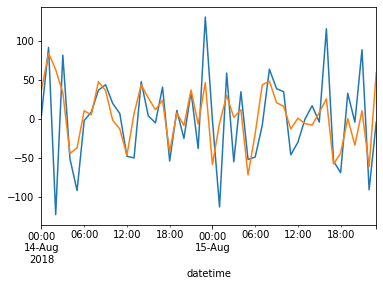

In [38]:
target_test    ['2018-08-14':'2018-08-15'].plot()
best_lr_predict['2018-08-14':'2018-08-15'].plot()

**Замечания:**
* на тестовой выборке лучшая по качеству предсказания модель из рассмотренных показала удовлитворительный результат (RMSE менее 48).

Второе по качеству предсказание из рассмотренных моделей показала модель `Случайного леса` при глубине `5` и количестве деревьев `20`.

In [39]:
best_rfr_model = RandomForestRegressor(max_depth   =5,
                                       n_estimators=20,
                                       random_state=0)

In [40]:
best_rfr_model.fit(features_train_valid, 
                   target_train_valid)

RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0)

In [41]:
best_rfr_predict = pd.Series(data =best_rfr_model.predict(features_test),
                             index=features_test.index)

In [42]:
mean_squared_error(target_test, best_rfr_predict, squared=False)

48.884712802190606

<AxesSubplot:xlabel='datetime'>

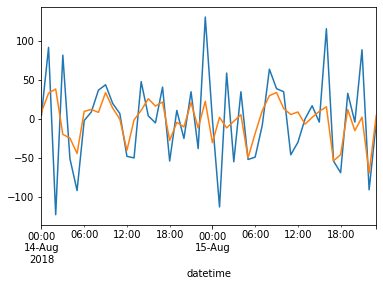

In [43]:
target_test     ['2018-08-14':'2018-08-15'].plot()
best_rfr_predict['2018-08-14':'2018-08-15'].plot()

**Замечания:**
* на тестовой выборке вторая по качеству предсказания модель из рассмотренных показала неудовлитворительный результат (RMSE более 48).

Последняя по качеству предсказания из рассмотренных моделей оказалась модель `Решающего дерева` при глубине дерева `4`.

In [44]:
best_dtr_model = DecisionTreeRegressor(max_depth   =4,
                                       random_state=0)

In [45]:
best_dtr_model.fit(features_train_valid, 
                   target_train_valid)

DecisionTreeRegressor(max_depth=4, random_state=0)

In [46]:
best_dtr_predict = pd.Series(data =best_dtr_model.predict(features_test),
                             index=features_test.index)

In [47]:
mean_squared_error(target_test, best_dtr_predict, squared=False)

50.34747960426802

<AxesSubplot:xlabel='datetime'>

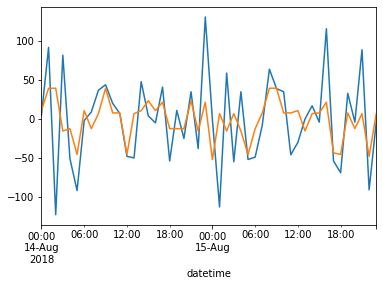

In [48]:
target_test     ['2018-08-14':'2018-08-15'].plot()
best_dtr_predict['2018-08-14':'2018-08-15'].plot()

**Замечания:**
* на тестовой выборке последняя по качеству предсказания модель из рассмотренных показала неудовлитворительный результат (RMSE более 48).

# Выводы
* при прогнозировании спроса на такси рекомендуется использовать модель линейной регрессии;
* при подготовке данных для модели рекомендуется использовать период в одни сутки для расчета скользящего среднего и для лага.